Training and evaluation of the GCRNN model.  
By: Shrey Patel

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4
!pip install -q datasets e2cnn

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 136.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

hf_ds = load_dataset(
    "Max-Ploter/detection-moving-mnist-easy",#split = "train"
    split="train[:10000]"
)

print("HF len:", len(hf_ds))
print("Example keys:", hf_ds[0].keys())
#should show: ['video', 'labels', 'center_points', 'bboxes', 'bboxes_keypoints', 'bboxes_labels']

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train/data-00000-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00001-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00002-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00003-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00004-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00005-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00006-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00007-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00008-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00009-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00010-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

train/data-00011-of-00012.arrow:   0%|          | 0.00/682M [00:00<?, ?B/s]

test/data-00000-of-00002.arrow:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

test/data-00001-of-00002.arrow:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

HF len: 10000
Example keys: dict_keys(['video', 'labels', 'center_points', 'bboxes', 'bboxes_keypoints', 'bboxes_labels'])


In [ ]:
class MovingMNISTHF(Dataset):
    def __init__(self, hf_dataset, num_digits=10):
        self.ds = hf_dataset
        self.num_digits = num_digits

    def __len__(self):
        return len(self.ds)

    def _process_video(self, video):
        video = np.array(video, dtype=np.float32)

        if video.ndim == 4:
            T, a, b, c = video.shape
            if c in (1, 3):
                video = video.mean(axis=-1)
            elif a in (1, 3):
                video = video.mean(axis=1)
            else:
                raise RuntimeError(f"Unexpected 4D video shape: {video.shape}")
        elif video.ndim == 3:
            if video.shape[0] in (1, 3) and video.shape[1] == video.shape[2]:
                video = video.mean(axis=0, keepdims=True)
        elif video.ndim == 2:
            video = video[None, :, :]
        else:
            raise RuntimeError(f"Unexpected video shape: {video.shape}")

        video /= 255.0
        video = video[:, None, :, :]
        video = video[::2]

        return video.astype(np.float32)

    def _process_labels(self, example):
        raw = example["labels"]
        labels_set = set()

        for frame_labels in raw:
            if frame_labels is None:
                continue
            for l in frame_labels:
                if isinstance(l, (int, np.integer)):
                    if 0 <= l < self.num_digits:
                        labels_set.add(int(l))

        labels = np.zeros(self.num_digits, dtype=np.float32)
        for l in labels_set:
            labels[l] = 1.0
        return labels

    def __getitem__(self, idx):
        example = self.ds[idx]

        video = self._process_video(example["video"])
        labels = self._process_labels(example)

        video = torch.from_numpy(video).float()
        labels = torch.from_numpy(labels).float()

        video = F.avg_pool2d(video, kernel_size=2)

        return video, labels


In [ ]:
full_ds = MovingMNISTHF(hf_ds)

train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size

train_ds, val_ds = random_split(
    full_ds,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_part_size = int(val_size / 5)
val_flip, val_90, val_180, val_270, val_normal = random_split(
    val_ds,
    [val_part_size, val_part_size, val_part_size, val_part_size, val_size - val_part_size * 4],
    generator=torch.Generator().manual_seed(42),
)

from torch.utils.data import Dataset

import torch

def apply_flip(batch):
    # Horizontal flip across width axis
    return torch.flip(batch, dims=[-1])   # flip width

def apply_rot90(batch):
    return torch.rot90(batch, k=1, dims=[-2, -1])

def apply_rot180(batch):
    return torch.rot90(batch, k=2, dims=[-2, -1])

def apply_rot270(batch):
    return torch.rot90(batch, k=3, dims=[-2, -1])


class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        x = self.transform(x)
        return x, y

val_flip  = TransformedSubset(val_flip,  apply_flip)
val_90    = TransformedSubset(val_90,    apply_rot90)
val_180   = TransformedSubset(val_180,   apply_rot180)
val_270   = TransformedSubset(val_270,   apply_rot270)

new_val_ds = torch.utils.data.ConcatDataset([val_flip, val_90, val_180, val_270, val_normal])

val_loader = DataLoader(
    new_val_ds,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

#Sanity Check
videos, labels = next(iter(train_loader))
print("videos.shape:", videos.shape)
print("labels.shape:", labels.shape)


videos.shape: torch.Size([16, 10, 1, 64, 64])
labels.shape: torch.Size([16, 10])


In [ ]:
import torch
import torch.nn as nn
from e2cnn import gspaces
from e2cnn import nn as enn

class EquivariantConvGRUCell(nn.Module):
    def __init__(self, gspace, in_type, hidden_type, kernel_size=3):
        super().__init__()
        self.gspace = gspace
        self.in_type = in_type
        self.hidden_type = hidden_type

        # equivariant convs:
        # map input -> hidden
        self.conv_x = enn.R2Conv(self.in_type, self.hidden_type,
                             kernel_size=kernel_size, padding=kernel_size//2, bias=False)

        # map hidden -> hidden (use kernel_size=1 for pointwise mixing if desired)
        self.conv_h = enn.R2Conv(self.hidden_type, self.hidden_type,
                             kernel_size=1, bias=False)

        # an equivariant nonlinearity (norm-based)
        self.nonlin = enn.NormNonLinearity(self.hidden_type, function='n_relu')

    def forward(self, x_geom: enn.GeometricTensor, h_geom: enn.GeometricTensor):
        # x_geom and h_geom must be GeometricTensor with types in_type and hidden_type
        # Map input to hidden representation (result is GeometricTensor)
        x_to_h = self.conv_x(x_geom)   # -> hidden_type
        h_to_h = self.conv_h(h_geom)   # -> hidden_type

        # sum is valid because both are same FieldType
        new_hidden = x_to_h + h_to_h

        # apply equivariant nonlinearity
        new_hidden = self.nonlin(new_hidden)

        return new_hidden

class GCRNNClassifier(nn.Module):
    def __init__(self, in_channels=1, cnn_dim=128, num_classes=10, kernel_size=5):
        super().__init__()
        self.gspace = gspaces.FlipRot2dOnR2(N=4)
        self.in_type = enn.FieldType(self.gspace, [self.gspace.trivial_repr])
        self.hidden_type = enn.FieldType(self.gspace, cnn_dim*[self.gspace.regular_repr])

        self.rnn_cell = EquivariantConvGRUCell(
            gspace=self.gspace,
            in_type=self.hidden_type,
            hidden_type=self.hidden_type,
        )

        self.pool = enn.GroupPooling(self.hidden_type)
        self.avgpool = enn.PointwiseAvgPool(self.hidden_type, 64)

        self.encoder = enn.SequentialModule(
            enn.R2Conv(self.in_type, self.hidden_type, kernel_size=kernel_size, padding=kernel_size//2),
            enn.InnerBatchNorm(self.hidden_type),
            enn.ReLU(self.hidden_type),
            enn.R2Conv(self.hidden_type, self.hidden_type, kernel_size=kernel_size, padding=kernel_size//2),
            enn.InnerBatchNorm(self.hidden_type),
            enn.ReLU(self.hidden_type),
            enn.R2Conv(self.hidden_type, self.hidden_type, kernel_size=kernel_size, padding=kernel_size//2),
        )

        self.fc = nn.Linear(cnn_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        h = enn.GeometricTensor(torch.zeros(B, self.hidden_type.size, H, W, device=x.device), self.hidden_type)
        for t in range(T):
            x_t = enn.GeometricTensor(x[:, t, :, :, :], self.in_type)
            x_t = self.encoder(x_t)
            h = self.rnn_cell(x_t, h)
        last_h = self.pool(self.avgpool(h)).tensor
        last_h = last_h.view(B, -1)
        logits = self.fc(last_h)
        return logits





In [ ]:
model = GCRNNClassifier(num_classes=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,patience=3)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    total_batches = 0

    for batch in tqdm(loader):
        videos, labels = batch

        videos = videos.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        logits = model(videos)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            batch_acc = (preds == labels).float().mean().item()

        epoch_loss += loss.item()
        epoch_acc += batch_acc
        total_batches += 1

    return epoch_loss / total_batches, epoch_acc / total_batches


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    epoch_acc = 0.0
    total_batches = 0

    for batch in tqdm(loader):
        videos, labels = batch

        videos = videos.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)

        logits = model(videos)
        loss = criterion(logits, labels)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        batch_acc = (preds == labels).float().mean().item()

        epoch_loss += loss.item()
        epoch_acc += batch_acc
        total_batches += 1

    return epoch_loss / total_batches, epoch_acc / total_batches


In [ ]:
num_epochs = 10
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

 10%|█         | 1/10 [1:16:36<11:29:32, 4596.95s/it]

Epoch 01 | Train Loss: 0.5672 | Train Acc: 0.6992 | Val Loss: 0.5506 | Val Acc: 0.7363



 20%|██        | 2/10 [2:33:09<10:12:34, 4594.31s/it]

Epoch 02 | Train Loss: 0.4254 | Train Acc: 0.8017 | Val Loss: 0.4128 | Val Acc: 0.8212



 30%|███       | 3/10 [3:49:50<8:56:20, 4597.22s/it] 

Epoch 03 | Train Loss: 0.3306 | Train Acc: 0.8589 | Val Loss: 0.3221 | Val Acc: 0.8575



 40%|████      | 4/10 [5:06:14<7:39:12, 4592.03s/it]

Epoch 04 | Train Loss: 0.2626 | Train Acc: 0.8944 | Val Loss: 0.2904 | Val Acc: 0.8834



 50%|█████     | 5/10 [6:22:33<6:22:16, 4587.34s/it]

Epoch 05 | Train Loss: 0.2183 | Train Acc: 0.9171 | Val Loss: 0.2125 | Val Acc: 0.9165



 60%|██████    | 6/10 [7:38:49<5:05:33, 4583.45s/it]

Epoch 06 | Train Loss: 0.1923 | Train Acc: 0.9288 | Val Loss: 0.1942 | Val Acc: 0.9258



 70%|███████   | 7/10 [8:54:54<3:48:52, 4577.62s/it]

Epoch 07 | Train Loss: 0.1680 | Train Acc: 0.9385 | Val Loss: 0.1697 | Val Acc: 0.9388



 80%|████████  | 8/10 [10:10:55<2:32:24, 4572.37s/it]

Epoch 08 | Train Loss: 0.1514 | Train Acc: 0.9460 | Val Loss: 0.1503 | Val Acc: 0.9454



 90%|█████████ | 9/10 [11:26:58<1:16:09, 4569.21s/it]

Epoch 09 | Train Loss: 0.1373 | Train Acc: 0.9515 | Val Loss: 0.1478 | Val Acc: 0.9492



100%|██████████| 10/10 [12:43:06<00:00, 4578.64s/it]

Epoch 10 | Train Loss: 0.1260 | Train Acc: 0.9560 | Val Loss: 0.1626 | Val Acc: 0.9420


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), "/content/drive/MyDrive/gcrnn_model.pth")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = GCRNNClassifier(num_classes=10).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/gcrnn_model.pth"))

/usr/local/lib/python3.12/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /pytorch/aten/src/ATen/native/IndexingUtils.h:37.)
  full_mask[mask] = norms.to(torch.uint8)


<All keys matched successfully>

In [ ]:
evaluate(model, val_loader, nn.BCEWithLogitsLoss(), device)

100%|██████████| 125/125 [19:40<00:00,  9.44s/it]


(0.1596987574696541, 0.9443000092506408)

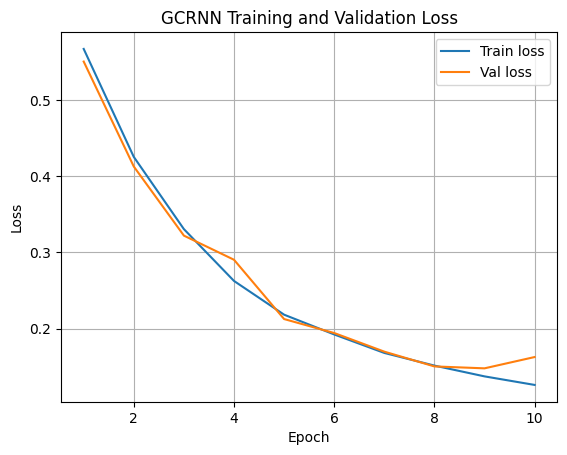

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# ---- Loss plot ----
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GCRNN Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

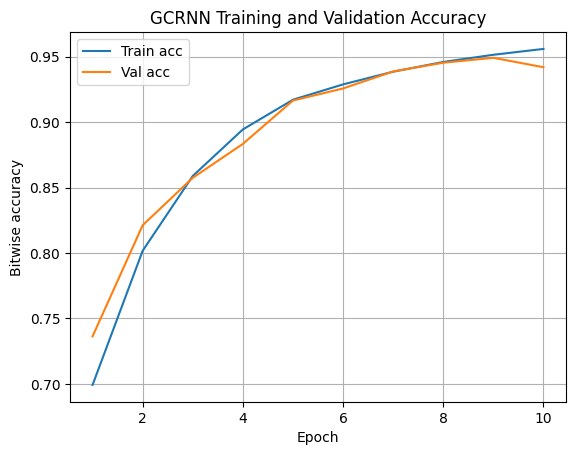

In [ ]:
# ---- Accuracy plot ----
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Bitwise accuracy")
plt.title("GCRNN Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()